In [15]:
"""
This module contains the atmospheric entry solver class
for the Deep Impact project
"""
import os
import numpy as np
import pandas as pd


__all__ = ['Planet']


class Planet():
    """
    The class called Planet is initialised with constants appropriate
    for the given target planet, including the atmospheric density profile
    and other constants
    """
    def __init__(self, atmos_func='exponential',
                 atmos_filename=os.path.join('resources','AltitudeDensityTable.csv'),
                 Cd=1., Ch=0.1, Q=1e7, Cl=1e-3, alpha=0.3,
                 Rp=6371e3, g=9.81, H=8000., rho0=1.2):
        """
        Set up the initial parameters and constants for the target planet

        Parameters
        ----------
        atmos_func : string, optional
            Function which computes atmospheric density, rho, at altitude, z.
            Default is the exponential function rho = rho0 exp(-z/H).
            Options are 'exponential', 'tabular' and 'constant'

        atmos_filename : string, optional
            Name of the filename to use with the tabular atmos_func option

        Cd : float, optional
            The drag coefficient

        Ch : float, optional
            The heat transfer coefficient

        Q : float, optional
            The heat of ablation (J/kg)

        Cl : float, optional
            Lift coefficient

        alpha : float, optional
            Dispersion coefficient

        Rp : float, optional
            Planet radius (m)

        rho0 : float, optional
            Air density at zero altitude (kg/m^3)

        g : float, optional
            Surface gravity (m/s^2)

        H : float, optional
            Atmospheric scale height (m)

        """

        # Input constants
        self.Cd = Cd
        self.Ch = Ch
        self.Q = Q
        self.Cl = Cl
        self.alpha = alpha
        self.Rp = Rp
        self.g = g
        self.H = H
        self.rho0 = rho0
        self.atmos_filename = atmos_filename

        try:
            # set function to define atmoshperic density
            if atmos_func == 'exponential':
                self.rhoa = lambda z: rho0 * np.exp(-z / H)
            elif atmos_func == 'tabular':
                self.read_csv()
                self.rhoa = lambda x: self.linear_interpolate(x)
            elif atmos_func == 'constant':
                self.rhoa = lambda x: rho0
            else:
                raise NotImplementedError(
                    "atmos_func must be 'exponential', 'tabular' or 'constant'"
                    )
        except NotImplementedError:
            print("atmos_func {} not implemented yet.".format(atmos_func))
            print("Falling back to constant density atmosphere for now")
            self.rhoa = lambda x: rho0

    def rk4_step(self, f, y, t, dt):
        """RK4."""
        k1 = dt * f(t, y)
        k2 = dt * f(t + dt / 2, y + k1 / 2)
        k3 = dt * f(t + dt / 2, y + k2 / 2)
        k4 = dt * f(t + dt, y + k3)
        return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    def solve_atmospheric_entry(
        self,
        radius,
        velocity,
        density,
        strength,
        angle,
        init_altitude=100e3,
        dt=0.25,
        radians=False,
    ):
        if not radians:
            angle = np.radians(angle)

        def equations_of_motion(t, y):
            v, m, theta, z, x, r = y
            rho_a = self.rhoa(z)
            A = np.pi * r**2

            dvdt = (-self.Cd * rho_a * A * v**2) / (2 * m) + self.g * np.sin(theta)
            dmdt = (-self.Ch * rho_a * A * v**3) / (2 * self.Q)
            dthetadt = (
                (self.g * np.cos(theta)) / v
                - (self.Cl * rho_a * A * v) / (2 * m)
                - (v * np.cos(theta)) / (self.Rp + z)
            )
            dzdt = -v * np.sin(theta)
            dxdt = (v * np.cos(theta)) / (1 + z / self.Rp)
            drdt = (
                np.sqrt((7 / 2) * self.alpha * (rho_a / density)) * v
                if rho_a * v**2 > strength
                else 0
            )

            return np.array([dvdt, dmdt, dthetadt, dzdt, dxdt, drdt])

        y0 = np.array(
            [
                velocity,
                density * (4 / 3) * np.pi * radius**3,
                angle,
                init_altitude,
                0,
                radius,
            ]
        )
        t = 0
        results = []
        fragmented = False
        user_time_elapsed = 0.0  # Initialize the user-specified time elapsed counter

        while True:
            #
            dt_actual = min(dt, 0.05)
            y0 = self.rk4_step(equations_of_motion, y0, t, dt_actual)
            t += dt_actual
            user_time_elapsed += dt_actual

            if user_time_elapsed >= dt:
                results.append([t] + list(y0))
                user_time_elapsed = 0.0  # Reset the user-specified time elapsed counter

            if y0[0] <= 531:
                break

            ram_pressure = self.rhoa(y0[3]) * y0[0] ** 2
            if ram_pressure > strength:
                fragmented = True
            elif fragmented and ram_pressure <= strength:
                fragmented = False

        result_df = pd.DataFrame(
            results,
            columns=[
                "time",
                "velocity",
                "mass",
                "angle",
                "altitude",
                "distance",
                "radius",
            ],
        )

        # Converts the angle column in the result from radians to degrees
        result_df["angle"] = np.degrees(result_df["angle"])

        return result_df


    def calculate_energy(self, result):
    # Calculate the kinetic energy at each step
        kinetic_energy = 0.5 * result['mass'] * result['velocity']**2

    # Convert kinetic energy from Joules to kilotons of TNT (1 kt TNT = 4.184e12 Joules)
        kinetic_energy_kt = kinetic_energy / 4.184e12

    # Calculate the energy change between successive steps
        energy_diff = np.diff(kinetic_energy_kt, prepend=kinetic_energy_kt[0])

    # Calculate the altitude difference between successive steps
        altitude_diff = np.diff(result['altitude'], prepend=result['altitude'][0])

    # Calculate dedz (change in energy per kilometer of altitude)
    # Note: Convert altitude change from meters to kilometers for correct units
    # Avoid division by zero by replacing zeros with a small number
        altitude_diff[altitude_diff == 0] = 1e-6
        dedz = energy_diff / (altitude_diff / 1000)

    # Update or create the 'dedz' column
        result['dedz'] = dedz

        return result


    def analyse_outcome(self, result):
        """
        Inspect a pre-found solution to calculate the impact and airburst stats.

        Parameters
        ----------
        result : DataFrame
            pandas dataframe with velocity, mass, angle, altitude, horizontal
            distance, radius and dedz as a function of time.

        Returns
        -------
        outcome : Dict
            dictionary with details of the impact event, which should contain
            the key:
                ``outcome`` (which should contain one of the
                following strings: ``Airburst`` or ``Cratering``),
            as well as the following 4 keys:
                ``burst_peak_dedz``, ``burst_altitude``,
                ``burst_distance``, ``burst_energy``.
        """

        outcome = {'outcome': 'Unknown',
                   'burst_peak_dedz': 0.,
                   'burst_altitude': 0.,
                   'burst_distance': 0.,
                   'burst_energy': 0.}
        # Check if the DataFrame is empty
        if result.empty:
            return outcome

        # Find the index of the maximum energy deposition rate
        max_dedz_idx = result['dedz'].idxmax()
        max_dedz = result.loc[max_dedz_idx, 'dedz']
        max_dedz_altitude = result.loc[max_dedz_idx, 'altitude']

        # Check if the max energy deposition occurs at an altitude above 0
        if max_dedz_altitude > 0:
            outcome['outcome'] = 'Airburst'
            outcome['burst_peak_dedz'] = max_dedz
            outcome['burst_altitude'] = max_dedz_altitude
            outcome['burst_distance'] = result.loc[max_dedz_idx, 'distance']
            # Calculate burst energy as the kinetic energy at the burst point
            burst_mass = result.loc[max_dedz_idx, 'mass']
            burst_velocity = result.loc[max_dedz_idx, 'velocity']
            outcome['burst_energy'] = 0.5 * burst_mass * burst_velocity**2 / 4.184e12  # in kt
        else:
            outcome['outcome'] = 'Cratering'
            # Additional details for cratering can be added based on specific criteria

        return outcome

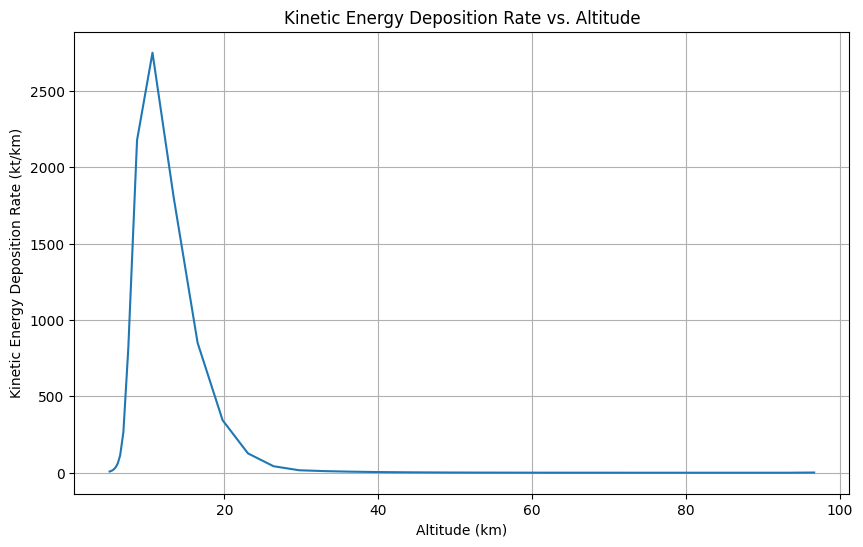

In [16]:
import matplotlib.pyplot as plt

# Create an instance of the Planet class
earth = Planet()

# Define the initial conditions for the atmospheric entry
radius = 35  # in meters
velocity = 19000  # in m/s
density = 3000  # in kg/m^3
strength = 1e7  # in Pascals
angle = 45  # in degrees

# Solve the atmospheric entry problem
result_df = earth.solve_atmospheric_entry(radius, velocity, density, strength, angle)

# Calculate the energy and dedz
result_df = earth.calculate_energy(result_df)

# Plot dedz vs. Altitude
plt.figure(figsize=(10, 6))
plt.plot(result_df['altitude'] / 1000, result_df['dedz'])
plt.xlabel('Altitude (km)')
plt.ylabel('Kinetic Energy Deposition Rate (kt/km)')
plt.title('Kinetic Energy Deposition Rate vs. Altitude')
plt.grid(True)
plt.show()


In [17]:
burst_altitude = result_df.loc[result_df['dedz'].idxmax(), 'altitude']

print (burst_altitude)

10671.19149237309


In [18]:
# Create an instance of the Planet class
earth = Planet()

# Define the initial conditions for the atmospheric entry
radius = 35  # in meters
velocity = 19000  # in m/s
density = 3000  # in kg/m^3
strength = 1e7  # in Pascals
angle = 45  # in degrees

# Solve the atmospheric entry problem
result_df = earth.solve_atmospheric_entry(radius, velocity, density, strength, angle)

# Get the final altitude from the last row of the DataFrame
final_altitude = result_df.iloc[-1]['altitude']

print (final_altitude)

5102.447047142278


In [5]:
# Calculate dedz (if not already calculated)
# Note: You need to add the calculate_energy function here that calculates dedz
result_df = earth.calculate_energy(result_df)

# Find the index of the maximum energy deposition rate
max_dedz_idx = result_df['dedz'].idxmax()

# Get the burst altitude at this index
burst_altitude = result_df.loc[max_dedz_idx, 'altitude']

print(f"Burst Altitude: {burst_altitude / 1000} km")


Burst Altitude: 10.671191492373088 km


In [19]:
    # Create an instance of the Planet class
earth = Planet()

# Define the initial conditions for the atmospheric entry
radius = 35  # in meters
velocity = 19000  # in m/s
density = 3000  # in kg/m^3
strength = 1e7  # in Pascals
angle = 45  # in degrees

# Solve the atmospheric entry problem
result_df = earth.solve_atmospheric_entry(radius, velocity, density, strength, angle)

# Display the DataFrame
print(result_df)  # or just `result_df` in Jupyter Notebooks


    time      velocity          mass      angle      altitude      distance  \
0   0.25  19001.732017  5.387830e+08  44.975476  96641.808504   3308.569415   
1   0.50  19003.462356  5.387827e+08  44.950922  93284.750349   6620.575462   
2   0.75  19005.190529  5.387823e+08  44.926340  89928.828462   9936.022131   
3   1.00  19006.915795  5.387816e+08  44.901728  86574.045879  13254.913311   
4   1.25  19008.637025  5.387806e+08  44.877087  83220.405805  16577.252729   
5   1.50  19010.352507  5.387791e+08  44.852416  79867.911694  19903.043870   
6   1.75  19012.059639  5.387769e+08  44.827717  76516.567381  23232.289847   
7   2.00  19013.754466  5.387734e+08  44.802988  73166.377269  26564.993205   
8   2.25  19015.430979  5.387681e+08  44.778229  69817.346632  29901.155625   
9   2.50  19017.080054  5.387601e+08  44.753442  66469.482056  33240.777470   
10  2.75  19018.687826  5.387480e+08  44.728624  63122.792118  36583.857103   
11  3.00  19020.233243  5.387295e+08  44.703778  597

C:\Users\mk1923\AppData\Local\Temp\ipykernel_13372\1906646045.py:13: RuntimeWarning: invalid value encountered in divide
  dedz = energy_diff / (altitude_diff / 1000)


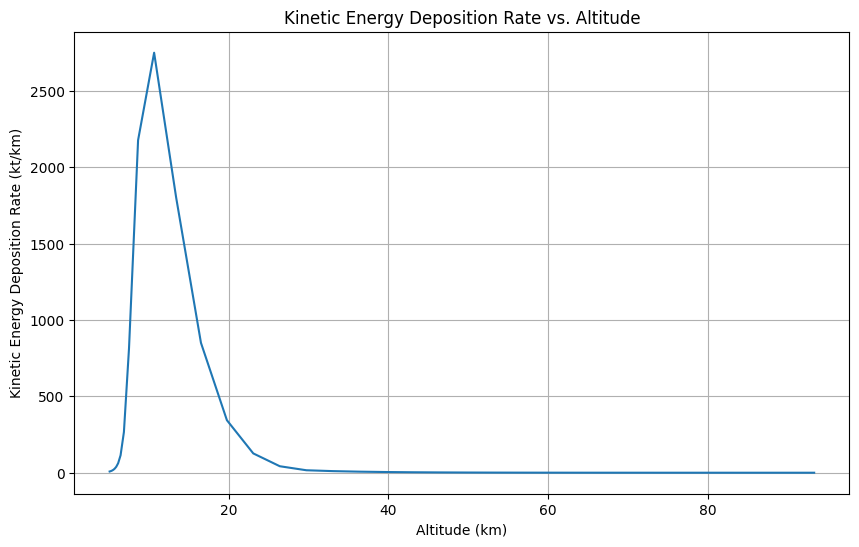

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the kinetic energy in kilotons of TNT
result_df['kinetic_energy_kt'] = result_df['mass'] * result_df['velocity']**2 / 2 / 4.184e12

# Calculate the change in kinetic energy and altitude
energy_diff = np.diff(result_df['kinetic_energy_kt'], prepend=result_df['kinetic_energy_kt'][0])
altitude_diff = np.diff(result_df['altitude'], prepend=result_df['altitude'][0])

# Calculate dedz (change in kinetic energy per kilometer of altitude)
# Convert altitude change from meters to kilometers
dedz = energy_diff / (altitude_diff / 1000)

# Add dedz to the DataFrame
result_df['dedz'] = dedz

# Plot dedz vs. Altitude
plt.figure(figsize=(10, 6))
plt.plot(result_df['altitude'] / 1000, result_df['dedz'])
plt.xlabel('Altitude (km)')
plt.ylabel('Kinetic Energy Deposition Rate (kt/km)')
plt.title('Kinetic Energy Deposition Rate vs. Altitude')
plt.grid(True)
plt.show()


We observe burst altitude at peak of our energy deposition rate, where we see maximumun of our de/dz or change in energy over altitude

In [20]:
# Create an instance of the Planet class
earth = Planet()

# Define the initial conditions for the atmospheric entry
radius = 35  # in meters
velocity = 19000  # in m/s
density = 3000  # in kg/m^3
strength = 1e7  # in Pascals
angle = 45  # in degrees

# Solve the atmospheric entry problem
result_df = earth.solve_atmospheric_entry(radius, velocity, density, strength, angle)

# Calculate the energy and dedz
result_df = earth.calculate_energy(result_df)

# Analyse the outcome
outcome = earth.analyse_outcome(result_df)

# Print the outcome
print(outcome)


{'outcome': 'Airburst', 'burst_peak_dedz': 2750.4566600817557, 'burst_altitude': 10671.19149237309, 'burst_distance': 89594.26631899436, 'burst_energy': 5554.775079575391}


In this function:

Airburst Determination: The function determines if the event is an airburst by checking if the maximum dedz occurs at an altitude greater than zero. If so, it records the details of the airburst, including peak dedz, burst altitude, distance, and energy.

Cratering Scenario: If the maximum dedz occurs at or below zero altitude, it categorizes the event as cratering. You may add additional logic to detail the cratering scenario based on your specific criteria.

Burst Energy Calculation: The burst energy is calculated as the kinetic energy at the point of maximum dedz, converted to kilotons of TNT.

This function provides a structured way to analyze the outcome of an atmospheric entry event based on the data in your result DataFrame.

In [21]:
import numpy as np

# Assuming dedz and altitude are in result_df with altitude decreasing from 100 km to 0 km

# Extract dedz and altitude values
y = result_df['dedz'].values  # dedz values
x = result_df['altitude'].values  # altitude values

# Apply the trapezoidal rule and take the absolute value
total_energy_dissipated_kt = np.abs(np.trapz(y, x))
print(f"Total kinetic energy dissipated: {total_energy_dissipated_kt} kt")

Total kinetic energy dissipated: 20638291.17702174 kt
